### CE88: Data Science for Smart Cities - 11/13/17

# *kNN: Transportation forecasting*

In this lab session, we will analyze mode choice as a function of ***delta_travel_time***, and ***delta_travel_cost***, the difference in travel time and cost between the transit travel option and the driving travel option. We will build a method to predict the travel mode for a trip based on the travel mode of the "nearest neighbors". 

In [177]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [179]:
mc = Table.read_table('modechoice_training_raw.csv')
mc

observation_id,choice,total_travel_time_walk_transit_walk,total_travel_time_drive_alone,total_travel_cost_walk_transit_walk,total_travel_cost_drive_alone
1,drive_alone,83.56,20.97,5.84,1.6817
2,drive_alone,87.38,22.16,4.83,1.6817
7,drive_alone,86.89,32.07,3.22,1.7501
9,walk_transit_walk,54.13,21.93,3.22,0.9
11,drive_alone,49.12,22.33,3.22,0.8334
15,walk_transit_walk,50.26,13.87,3.22,0.7244
16,walk_transit_walk,50.26,13.87,3.22,0.7244
17,walk_transit_walk,66.25,22.39,3.22,1.4599
18,walk_transit_walk,64.2,21.11,3.22,1.0441
19,walk_transit_walk,161,24.02,3.22,1.8462


# 1. Data processing
## 1.1 Compare drive vs. transit travel time/cost

We compute the ***delta_travel_time*** and ***delta_travel_cost*** for trips where choice = transit and where choice = drive. 

In [86]:
# From transit_drive_avail, store the rows where the mode 'choice' is 'walk_transit_walk'
# in a table called took_transit
took_transit = mc.where('choice','walk_transit_walk')

# from transit_drive_avail, store the rows where the selected mode 'choice' is 'drive_alone'
drove = mc.where('choice','drive_alone')

# Compute the difference in travel time (the 'total_travel_time_walk_transit_walk' column-
# the 'total_travel_time_drive_alone' column) for people who took transit.
chose_wtw_tt_delta = (took_transit.column('total_travel_time_walk_transit_walk')-
                      took_transit.column('total_travel_time_drive_alone'))

# Compute the difference in travel time (the 'total_travel_time_walk_transit_walk' column-
# the 'total_travel_time_drive_alone' column) for people who drove.
chose_drive_tt_delta = (drove.column('total_travel_time_walk_transit_walk')-
                        drove.column('total_travel_time_drive_alone'))

# Compute the cost delta for transit cost vs. drive alone cost for people who took tranist
chose_wtw_cost_delta = (took_transit.column('total_travel_cost_walk_transit_walk')
                        -took_transit.column('total_travel_cost_drive_alone'))

# Compute the cost delta for transit cost vs. drive alone cost for people who drove
chose_drive_cost_delta = (drove.column('total_travel_cost_walk_transit_walk')
                          -drove.column('total_travel_cost_drive_alone'))

## 1.2 Visualize the data
Visualize the data to see what the data set looks like.

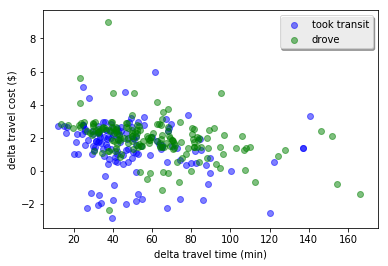

In [87]:
plt.scatter(chose_wtw_tt_delta, chose_wtw_cost_delta, color='blue', 
            alpha=.5, label = 'took transit')

plt.scatter(chose_drive_tt_delta, chose_drive_cost_delta, color='green', alpha=.5, label = 'drove')

plt.xlabel('delta travel time (min)')
plt.ylabel('delta travel cost ($)')
plt.legend(shadow=True)


## 1.3 Build the input data table
We need to build a table that contains the response variable (the thing we want to predict - in this case, whether someone will drive or not), and the inputs that will be used to predict the response variable (in this case ***delta_travel_time*** and ***delta_travel_cost***). 

In [88]:
# First create a table that contains the inputs of choice = drive alone
input_table = Table().with_columns('transit_time-drive_time', chose_drive_tt_delta,
                                   'transit_cost-drive_cost', chose_drive_cost_delta,
                                   'choice=drive',1)

# And create a table that contains the inputs of choice = walk transit walk
transit_input_table = Table().with_columns('transit_time-drive_time', chose_wtw_tt_delta,
                                           'transit_cost-drive_cost', chose_wtw_cost_delta,
                                           'choice=drive',0)
# Then merge the tables
input_table.append(transit_input_table)

transit_time-drive_time,transit_cost-drive_cost,choice=drive
62.59,4.1583,1
65.22,3.1483,1
54.82,1.4699,1
26.79,2.3866,1
41.49,2.5436,1
57.78,2.004,1
94.82,0.1838,1
13.38,2.8282,1
68.36,2.394,1
32.56,2.2979,1


## 1.4 Normalize the data.
If the input data columns are all in the same units, then we're good to go, but if they are in different units, i.e one column contains travel time in minutes and another column contains travel cost in dollars, a distance measure doesn't make a lot of sense. Instead we normalize the data and for every column. The "units" of the normalized data is how many standard deviations the data point is from the mean. I have built a norm() helper function to normalize the data. Later we will use the transform function to modify a new point that we want to predict in the same that we have modified the other points.

In [89]:
def norm(data):
    x_minus_mean = data - np.mean(data)
    x_norm = x_minus_mean/np.std(data)
    return x_norm

def transform(to_predict, data):
    return (to_predict - np.mean(data))/np.std(data)


# Your task: create two new columns in the table, one called 'normed_transit_time-drive_time', 
#            another called 'normed_transit_cost-drive_cost'. The values in these two columns should be
#            the normalized values of 'transit_time-drive_time' and 'transit_cost-drive_cost'. Use the
#            norm() function above to help you out:

#Answer key:
input_table['normed_transit_time-drive_time'] = norm(input_table['transit_time-drive_time'])
input_table['normed_transit_cost-drive_cost'] = norm(input_table['transit_cost-drive_cost'])

# 2. Build a classifier


## 2.1 Determine a distance function
Since we need to identify the nearest neighbors, we first need to choose a distance function. In this case we will use a euclidean distance function.

The euclidean distance between two points x=(x1,x2) and y=(y1,y2) is determined as
$ \sqrt{(x_1-y_1)^2 + (x_2-y_2)^2} $

In [157]:
def distance(x, y):
    #Your task: complete the function that returns an array of 
    #           the euclidean distance between each element of x and y
    #           where x and y are multi-dimensional arrays
    #           consisting of the coordinates of points
    #           e.g., x = [[0,0],[1,0],[1,1]], y = [[1,0],[0,0],[0,0]]
    #(HINT: use np.sqrt() to get a squared root)
    # Answer key:
    return np.sqrt(np.sum((x-y)**2,1))

# Verify your function:
x = np.array([[0,0],[1,0],[1,1]])
y = np.array([[1,0],[0,0],[0,0]])
print(distance(x, y)) # This must print: [ 1. 1. 1.41421356]

# This should also work with a single point...
x = [0,0]
y = np.array([[1,0],[1,1],[0,1]])
print(distance(x, y)) # This must print: [ 1. 1.41421356  1.]

[ 1.          1.          1.41421356]
[ 1.          1.41421356  1.        ]


## 2.2 Determine a function to find the k nearest points

In [176]:
def predict(input_table, to_predict, k, return_kneighbor_inds=True):
    '''
    to_predict: A single input data point. It should contain one value 
       for each of the columns in the input_data table.
    return_kneighbor_inds: boolean. If True, return the indices of the
        nearest neighbors from the input table, otherwise, only the 
        majority category of the k-nearest neighbors is returned.
    '''

    # Your task: get input data as a multi-demensional array that has two columns: 
    #           'normed_transit_time-drive_time' and 'normed_transit_cost-drive_cost'
    # (HINT: use "Table.values" to convert a Table to an array)
    # Answer key:
    input_data = input_table.select(['normed_transit_time-drive_time','normed_transit_cost-drive_cost']).values

    # Your task: get distance between input_data to to_predict
    # Answer key:
    dists = distance(to_predict, input_data)

    # Your task: get indices of k nearest points
    # (HINT: use np.argsort(array) to get an index array of values sorted in ascending order)
    # Answer Key:
    inds = np.argsort(dists)[0:k]

    # Your task: return the most common response among the neighbors
    # (HINT: use np.bincount() to get an array of counts of duplicated elements))
    most_common_response = np.argmax(np.bincount(input_table['choice=drive'][inds]))
    
    if return_kneighbor_inds:
        print('responses: ' + str(input_table['choice=drive'][inds]))
        print('counts: ' + str(np.bincount(input_table['choice=drive'][inds])))
        return most_common_response, inds
    return most_common_response

# Example of np.argsort()
print("result of np.argsort([1,3,2]): " + str(np.argsort([1,3,2])))

# Example of np.bincount():
print("result of np.bincount([0,1,1,0,0,0]): " + str(np.bincount([0,1,1,0,0,0])))

result of np.argsort([1,3,2]): [0 2 1]
result of np.bincount([0,1,1,0,0,0]): [4 2]


## 2.3 Prediction example

### 2.3a Prediction

In [174]:
# Determine k
k = 5

# Set to_predict =[25,1.5] This means we are predicting the travel mode of a trip with 
# delta_travel_time = 25 min, delta_travel_cost = 1.5
to_predict = [25,1.5]

#transform the first element of this point to find out how many standard deviations 
#the delta_travel_time is from the mean. Do the same for delta_travel_cost
normed_to_predict = [transform(to_predict[0],input_table['transit_time-drive_time']),
                     transform(to_predict[1],input_table['transit_cost-drive_cost'])]
print('normed_to_predict: ' + str(normed_to_predict))


prediction, nn_inds = predict(input_table, normed_to_predict, k, True)
predicted_travel_mode = 'drive' if prediction ==1 else 'take transit'

print ('Based on the k=%d nearest neighbors, the predicted travel mode is %s' %(k,predicted_travel_mode))

normed_to_predict: [-1.1612124055238295, -0.14820104900504455]
responses: [0 0 0 0 0]
counts: [5]
Based on the k=5 nearest neighbors, the predicted travel mode is take transit


### 2.3b Verify results
Make sure we are actually locating the nearest neighbors. In the cell below we use the Table take() method to see which rows have been identied as nearest neighbors. Take a look at the values and confirm that they are similar to the values of the to_predict point. 

In [95]:
input_table.take[nn_inds]

transit_time-drive_time,transit_cost-drive_cost,choice=drive,normed_transit_time-drive_time,normed_transit_cost-drive_cost
25.81,1.5818,0,-1.1306,-0.0898501
30.01,1.494,0,-0.971883,-0.152481
21.05,1.7231,0,-1.31048,0.0109444
31.12,1.4673,0,-0.929936,-0.171527
27.35,1.8525,0,-1.07241,0.10325


### 2.3c Visualize the nearest neighbors
Below is the same scatter poing that we plotted above, but now we have added a black dot for the to_predict point, and added red circles to identify the nearest neighbors to the observed point.

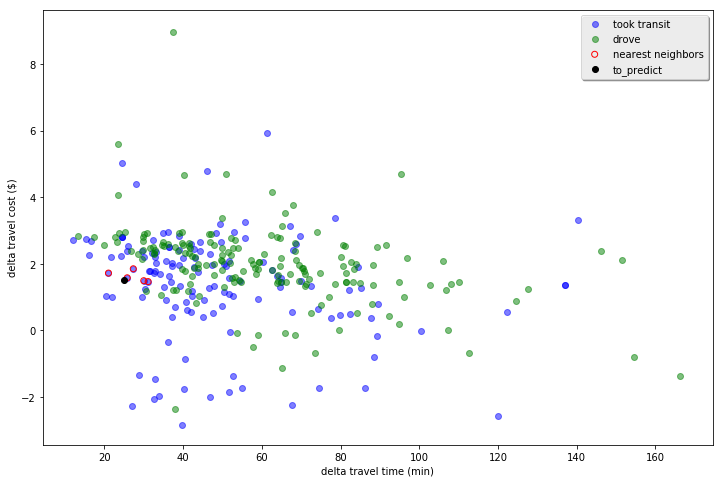

In [96]:
plt.figure(figsize=(12,8))

nn_to_plot = input_table.take[nn_inds]

plt.scatter(chose_wtw_tt_delta, chose_wtw_cost_delta, color='blue', 
            alpha=.5, label = 'took transit')
plt.scatter(chose_drive_tt_delta, chose_drive_cost_delta, color='green', 
            alpha=.5, label = 'drove')
plt.scatter(nn_to_plot['transit_time-drive_time'], nn_to_plot['transit_cost-drive_cost'], 
            facecolors='none', edgecolors='red', label = 'nearest neighbors')
plt.scatter([to_predict[0]],[to_predict[1]], color='black', label = 'to_predict')

plt.xlabel('delta travel time (min)')
plt.ylabel('delta travel cost ($)')
plt.legend(shadow=True)

## 3.4 Classification accuracy

### 3.4a Load training dataset
We already processed the testing dataset as we did for the training dataset.

In [108]:
# load training dataset
test = Table.read_table('modechoice_testing_input.csv')
test

transit_time-drive_time,transit_cost-drive_cost,choice=drive,normed_transit_time-drive_time,normed_transit_cost-drive_cost
52.97,2.1071,1,-0.16279,0.372703
47.96,1.8857,1,-0.328026,0.229221
37.95,3.0421,1,-0.658168,0.978644
23.99,2.599,1,-1.11859,0.691486
38.33,2.381,1,-0.645635,0.550208
17.52,2.381,1,-1.33197,0.550208
114.2,0.995,1,1.85665,-0.34801
100.38,0.8841,1,1.40085,-0.419881
45.79,2.1556,1,-0.399595,0.404134
48.43,1.7324,1,-0.312525,0.129873


### 3.4b Predict testing datasets given training dataset and store the predictions in a new column

In [131]:
# determine k
k = 5

# Your task: predict each row of test dataset with respect to "normed_transit_time-drive_time" 
#           and "normed_transit_cost-drive_cost" based on the training dataset, "input_table", 
#           and store the predictions in a new column "predicted" in the test table
# (HINT: use Table.apply(lambda x,y: YOUR_FUNCTION_OF_(x,y), ['column1','column2']) that we learned in lab#2)

# Answer key: 
test['predicted'] = test.apply(lambda time, cost: predict(input_table, [time, cost], k, False), 
                                ['normed_transit_time-drive_time','normed_transit_cost-drive_cost'])
test

transit_time-drive_time,transit_cost-drive_cost,choice=drive,normed_transit_time-drive_time,normed_transit_cost-drive_cost,predicted
52.97,2.1071,1,-0.16279,0.372703,1
47.96,1.8857,1,-0.328026,0.229221,1
37.95,3.0421,1,-0.658168,0.978644,0
23.99,2.599,1,-1.11859,0.691486,0
38.33,2.381,1,-0.645635,0.550208,1
17.52,2.381,1,-1.33197,0.550208,0
114.2,0.995,1,1.85665,-0.34801,1
100.38,0.8841,1,1.40085,-0.419881,1
45.79,2.1556,1,-0.399595,0.404134,0
48.43,1.7324,1,-0.312525,0.129873,1


### 3.4c Compute the accuracy

In [132]:
# Your task: compute the accuracy of the predictions. 
# (HINT: use np.count_nonzero() to count correct predictions)

# Answer key:
accuracy = np.count_nonzero(test.column('choice=drive') == test.column('predicted'))

print("Prediction accuracy: " + str(accuracy) + "%")

Prediction accuracy: 51%


### (Optional) IF time allows...

### Questions:
* What is the kNN predicted travel mode when delta_travel_time = 50, delta_travel_cost = 1.5 when we use... 
 - 1 nearest neighbors to predict travel mode? 
 - 3 nearest neighbors to predict travel mode? 
 - 5 nearest neighbors to predict travel mode? 
 - 10 nearest neighbors to predict travel mode? 
 - 50 nearest neighbors to predict travel mode?



* Describe in words the decision rule (how we decide the travel mode) for k-nearest neighbors when k=1?


* Describe in words the decision rule (how we decide the travel mode) for k-nearest neighbors when k=10?


* For the task of classifying travel mode, do you think it makes more sense to use k=1 or k=10?

In [ ]:
# 1 nearest neighbor: would use transit
# 3 nearest neighbors: would use transit 
# 5 nearest neighbors: would drive 
# 10 nearest neighbors: would drive
# 50 nearest neighbors: would drive

# Describe in words the decision rule (how we decide the travel mode) for k-nearest neighbors when k=1?
# Take the travel mode of the one closest (most similar) data point - this is the predicted travel mode

# Describe in words the decision rule (how we decide the travel mode) for k-nearest neighbors when k=10?
# Take the travel mode of the 10 closest (most similar) data point - we predict the travel mode as the 
# majority vote of the 10 nearest neighbors. I.e. if more than half of the 10 neighbors drive, 
# predict dirve, otherwise predict transit.

# For the task of classifying travel mode, do you think it makes more sense to use k=1 or k=10?
# Probably 10 neighbors will give more stable answers, 1 Nearest Neighbot is susceptible to outliers
# I.e. if one traveler happens to choose transit, despite having a high delta TT and high delta cost
# if we only use 1 nearest neighbor, we would predict that other travelers with high delta TT and 
# high delta cost will also take transit, even though this result is counter-intuitive. Using 10
# nearest neighbors is not as susceptible to outliers. 